<a href="https://colab.research.google.com/github/plue1011/PyTorch/blob/master/practice/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Apr 22 17:21:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
import copy
import glob
import re
import pandas as pd
from tqdm.notebook import tqdm as tqdm

%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optimizers
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision import models

from sklearn.metrics import accuracy_score

# データ作成

## データの読み込み

In [5]:
root_path = '/content/drive/My Drive/study/CNN/dataset/CIFAR10'
train_set = torchvision.datasets.CIFAR10(root=root_path, train=True, download=True)
test_set = torchvision.datasets.CIFAR10(root=root_path, train=False, download=True)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## 飛行機と車だけ抽出

In [0]:
# train_set_class01 = []
# train_labels = []
# for data, label in train_set:
#     if label == 0 or label == 1:
#         train_set_class01.append(data)
#         train_labels.append(label)

# test_set_class01 = []
# test_labels = []
# for data, label in test_set:
#     if label == 0 or label == 1:
#         test_set_class01.append(data)
#         test_labels.append(label)

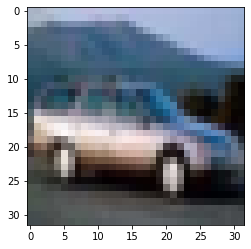

In [0]:
# (32, 32)
plt.imshow(np.array(train_set_class01[0]))
plt.show()

リサイズして、(32, 32)の画像を(300, 300)の画像に変換している

In [0]:
train_set_class01 = [cv2.resize(np.array(data), (300, 300)) for data in train_set_class01]
test_set_class01 = [cv2.resize(np.array(data), (300, 300)) for data in test_set_class01]

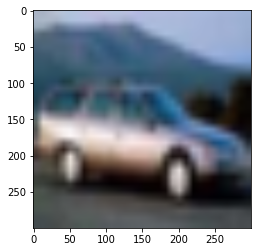

In [0]:
# (300, 300)
plt.imshow(train_set_class01[0])
plt.show()

##  transformの作成

In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),  # tensor型に変換
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 画像を正規化
    ])

## Datasetの作成

In [0]:
class MyDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.transform = transform
        self.dataset = dataset
        self.data = []
        self.label = []
        for d, l in self.dataset:
            if l == 0 or l == 1:
                self.data.append(cv2.resize(np.array(d), (300, 300)))
                self.label.append(l)

    def __len__(self):
        return len(self.label)

    # データをtransformで前処理してから返している
    def __getitem__(self, idx):
        out_data = self.data[idx]
        out_label =  self.label[idx]

        if self.transform:
            out_data = self.transform(out_data)

        return out_data, out_label

train_dataset = MyDataset(train_set, transform)
test_dataset = MyDataset(test_set, transform)

## DataLoaderの作成

In [0]:
# 訓練データをさらに「訓練データ」と「検証データ」に分ける(検証データ!=テストデータ)
n_samples = len(train_dataset)
n_train = int(n_samples * 0.8)
n_val = n_samples - n_train
train_dataset, val_dataset = random_split(train_dataset, [n_train, n_val])

BATCH = 128
train_dataloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH, shuffle=False)

In [9]:
train_dataset[0][0].size()

torch.Size([3, 300, 300])

# 簡単なCNN

## モデルの構築

In [0]:
# モデルの構築
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 72 * 72, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 2)

    def forward(self, x):
        # print("0", x.size())
        x = self.pool(F.relu(self.conv1(x)))
        # print("1", x.size())
        x = self.pool(F.relu(self.conv2(x)))
        # print("2", x.size())
        x = x.view(-1, 16 * 72 * 72)
        # print("3", x.size())
        x = F.relu(self.fc1(x))
        # print("4", x.size())
        x = F.relu(self.fc2(x))
        # print("5", x.size())
        x = self.fc3(x)
        # print("6", x.size())
        return x

In [0]:
# モデルの構築
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # cpuかgpuのどちらのデバイスを使っているかを代入する
model = CNN().to(device)

# 誤差関数の定義
compute_loss = nn.CrossEntropyLoss()

# 最適化手法の定義
optimizer = optimizers.Adam(model.parameters(),
                            lr=0.001,
                            betas=(0.9, 0.999), 
                            amsgrad=True)

## 学習

In [0]:
# 関数

## 学習の早期終了
class EarlyStopping:
    '''
    早期終了 (early stopping)
    '''
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience = patience
        self.verbose = verbose

    def __call__(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print('early stopping')
                return True
        else:
            self._step = 0
            self._loss = loss

        return False

## 1ステップ分の訓練のための関数
def train_step(x, t):
    model.train()  # モデルを訓練モードに設定する
    preds = model(x)  # modelにxを代入して、予測させる
    loss = compute_loss(preds, t)  # 予測値と正解との誤差を求める
    optimizer.zero_grad()  # 勾配を初期化する
    loss.backward()  # 勾配を計算する
    optimizer.step()  # パラメータを更新する
    return loss, preds

## 1ステップ分の訓練のための関数
def val_step(x, t):
    model.eval()  # モデルを評価モードに設定する
    preds = model(x)  # modelにxを代入して、予測させる
    loss = compute_loss(preds, t)  # 予測値と正解との誤差を求める    
    return loss, preds

## テストデータの評価関数
def test_step(x, t):
    return val_step(x, t)

In [0]:
# 学習
## 設定
epochs = 100  # エポック数を設定する
hist = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
es = EarlyStopping(patience=10, verbose=1)  # 10回以上誤差が小さくならないと早期終了する

np.random.seed(123)
torch.manual_seed(123)

## モデルの学習
for epoch in range(epochs):
    train_loss = 0.
    train_acc = 0.
    val_loss = 0.
    val_acc = 0.

    # 訓練パート
    for (x, t) in train_dataloader:
        x, t = x.to(device), t.to(device)
        loss, preds = train_step(x, t)
        train_loss += loss.item()
        train_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    # 検証パート
    for (x, t) in val_dataloader:
        x, t = x.to(device), t.to(device)
        loss, preds = val_step(x, t)
        val_loss += loss.item()
        val_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())

    val_loss /= len(val_dataloader)
    val_acc /= len(val_dataloader)

    # 学習状況を保存
    hist['loss'].append(train_loss)
    hist['accuracy'].append(train_acc)
    hist['val_loss'].append(val_loss)
    hist['val_accuracy'].append(val_acc)

    print('epoch: {}, loss: {:.3}, acc: {:.3f}'
          ', val_loss: {:.3}, val_acc: {:.3f}'.format(
              epoch+1,
              train_loss,
              train_acc,
              val_loss,
              val_acc
          ))

    if es(val_loss):
        break

KeyboardInterrupt: ignored

## モデルの評価

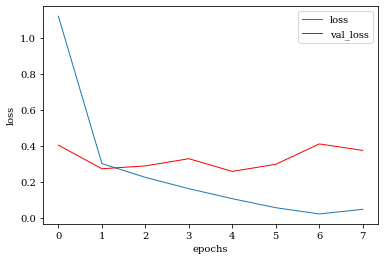

In [0]:
# テストデータの評価関数
def test_step(x, t):
    return val_step(x, t)

# 検証データの誤差の可視化
loss = hist['loss']
val_loss = hist['val_loss']

fig = plt.figure()
plt.rc('font', family='serif')
plt.plot(range(len(loss)), loss, linewidth=1,
             label='loss')
plt.plot(range(len(val_loss)), val_loss,
             color='red', linewidth=1,
             label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## 予測

In [0]:
test_loss = 0.
test_acc = 0.

for (x, t) in test_dataloader:
    x, t = x.to(device), t.to(device)
    loss, preds = test_step(x, t)
    test_loss += loss.item()
    test_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())

test_loss /= len(test_dataloader)
test_acc /= len(test_dataloader)
print('test_loss: {:.3f}, test_acc: {:.3f}'.format(
        test_loss,
        test_acc
))

test_loss: 0.449, test_acc: 0.901


# VGG16(転移学習)

## VGG-16の学習済みパラメータをとってくる

In [0]:
import os
import urllib.request

# VGG16の学習済みパラメータ
url = "https://s3.amazonaws.com/amdegroot-models/vgg16_reducedfc.pth"

save_dir = "/content/drive/My Drive/study/CNN/weights/"
target_path = os.path.join(save_dir, "vgg16_reducedfc.pth") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)

## モデルの構築

In [10]:
def make_vgg():
    layers = []
    in_channels = 3  # 色チャネル数

    # vggモジュールで使用する畳み込み層やマックスプーリングのチャネル数
    cfg = [64, 64, 'M', 
           128, 128, 'M', 
           256, 256, 256, 'MC', 
           512, 512, 512, 'M', 
           512, 512, 512]

    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == 'MC':
            # ceilは出力サイズを、計算結果（float）に対して、切り上げで整数にするモード
            # デフォルトでは出力サイズを計算結果（float）に対して、切り下げで整数にするfloorモード
            layers += [nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v

    pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    layers += [pool5]

    conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)
    conv7 = nn.Conv2d(1024, 1024, kernel_size=1)
    layers += [conv6, nn.ReLU(inplace=True), conv7, nn.ReLU(inplace=True)]
    return nn.ModuleList(layers)

# 動作確認
vgg_test = make_vgg()
print(vgg_test)

ModuleList(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (17): Conv2d(256, 512, kernel_siz

In [0]:
# # モデルの構築
# class VGG16(nn.Module):
#     def __init__(self):
#         super(VGG16, self).__init__()
#         self.vgg = make_vgg()

#         self.fc1 = nn.Linear(1024 * 19 * 19, 512)
#         self.b1 = nn.BatchNorm1d(512)
#         self.fc2 = nn.Linear(512, 512)
#         self.b2 = nn.BatchNorm1d(512)
#         self.fc3 = nn.Linear(512, 2)

#         self.affine_drop = nn.Dropout(p=0.5)

#     def forward(self, x):
#         for k in range(len(self.vgg)):
#             x = self.vgg[k](x)
#         x = x.view(-1, 1024 * 19 * 19)
#         x = F.relu(self.b1(self.fc1(x)))
#         x = self.affine_drop(x)
#         x = F.relu(self.b2(self.fc2(x)))
#         x = self.affine_drop(x)
#         x = self.fc3(x)

#         return x

In [0]:
# モデルの構築(深くしすぎた悪例)
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.vgg = make_vgg()

        self.fc1 = nn.Linear(1024 * 19 * 19, 64)
        self.b1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        for k in range(len(self.vgg)):
            x = self.vgg[k](x)
        x = x.view(-1, 1024 * 19 * 19)
        x = F.relu(self.b1(self.fc1(x)))
        x = self.fc2(x)

        return x

In [0]:
# モデルの構築
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # cpuかgpuのどちらのデバイスを使っているかを代入する
model = VGG16().to(device)

In [13]:
for name, param in model.named_parameters():
    print(name)

vgg.0.weight
vgg.0.bias
vgg.2.weight
vgg.2.bias
vgg.5.weight
vgg.5.bias
vgg.7.weight
vgg.7.bias
vgg.10.weight
vgg.10.bias
vgg.12.weight
vgg.12.bias
vgg.14.weight
vgg.14.bias
vgg.17.weight
vgg.17.bias
vgg.19.weight
vgg.19.bias
vgg.21.weight
vgg.21.bias
vgg.24.weight
vgg.24.bias
vgg.26.weight
vgg.26.bias
vgg.28.weight
vgg.28.bias
vgg.31.weight
vgg.31.bias
vgg.33.weight
vgg.33.bias
fc1.weight
fc1.bias
b1.weight
b1.bias
fc2.weight
fc2.bias


In [14]:
vgg_weights = torch.load("/content/drive/My Drive/study/CNN/weights/vgg16_reducedfc.pth")
model.vgg.load_state_dict(vgg_weights)

<All keys matched successfully>

In [15]:
# 転移学習で学習させるパラメータを、変数params_to_updateに格納する
params_to_update = []

# 学習させるパラメータ名
update_param_names = ["fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias", "fc3.weight", "fc3.bias"]

# 学習させるパラメータ以外は勾配計算をなくし、変化しないように設定
for name, param in model.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

fc1.weight
fc1.bias
fc2.weight
fc2.bias


In [0]:
# 誤差関数の定義
compute_loss = nn.CrossEntropyLoss()

# 最適化手法の定義
optimizer = optimizers.Adam(model.parameters(),
                            lr=0.0000001,
                            betas=(0.9, 0.999), 
                            amsgrad=True)

## 学習

In [0]:
# 関数

## 学習の早期終了
class EarlyStopping:
    '''
    早期終了 (early stopping)
    '''
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience = patience
        self.verbose = verbose

    def __call__(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print('early stopping')
                return True
        else:
            self._step = 0
            self._loss = loss

        return False

## 1ステップ分の訓練のための関数
def train_step(x, t):
    model.train()  # モデルを訓練モードに設定する
    preds = model(x)  # modelにxを代入して、予測させる
    loss = compute_loss(preds, t)  # 予測値と正解との誤差を求める
    optimizer.zero_grad()  # 勾配を初期化する
    loss.backward()  # 勾配を計算する
    optimizer.step()  # パラメータを更新する
    return loss, preds

## 1ステップ分の訓練のための関数
def val_step(x, t):
    model.eval()  # モデルを評価モードに設定する
    preds = model(x)  # modelにxを代入して、予測させる
    loss = compute_loss(preds, t)  # 予測値と正解との誤差を求める    
    return loss, preds

## テストデータの評価関数
def test_step(x, t):
    return val_step(x, t)

In [18]:
# 学習
## 設定
epochs = 20  # エポック数を設定する
hist = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
es = EarlyStopping(patience=20, verbose=1)  # 10回以上誤差が小さくならないと早期終了する

np.random.seed(123)
torch.manual_seed(123)

## モデルの学習
for epoch in range(epochs):
    train_loss = 0.
    train_acc = 0.
    val_loss = 0.
    val_acc = 0.

    # 訓練パート
    for (x, t) in tqdm(train_dataloader, leave=False):
        x, t = x.to(device), t.to(device)
        loss, preds = train_step(x, t)
        train_loss += loss.item()
        train_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    # 検証パート
    for (x, t) in tqdm(val_dataloader, leave=False):
        x, t = x.to(device), t.to(device)
        loss, preds = val_step(x, t)
        val_loss += loss.item()
        val_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())

    val_loss /= len(val_dataloader)
    val_acc /= len(val_dataloader)

    # 学習状況を保存
    hist['loss'].append(train_loss)
    hist['accuracy'].append(train_acc)
    hist['val_loss'].append(val_loss)
    hist['val_accuracy'].append(val_acc)

    print('epoch: {}, loss: {:.3}, acc: {:.3f}'
          ', val_loss: {:.3}, val_acc: {:.3f}'.format(
              epoch+1,
              train_loss,
              train_acc,
              val_loss,
              val_acc
          ))

    if es(val_loss):
        break        

epoch: 1, loss: 0.503, acc: 0.788, val_loss: 0.692, val_acc: 0.489


epoch: 2, loss: 0.375, acc: 0.869, val_loss: 0.398, val_acc: 0.818


epoch: 3, loss: 0.327, acc: 0.892, val_loss: 0.319, val_acc: 0.895


epoch: 4, loss: 0.301, acc: 0.905, val_loss: 0.295, val_acc: 0.898


epoch: 5, loss: 0.281, acc: 0.916, val_loss: 0.308, val_acc: 0.905


epoch: 6, loss: 0.269, acc: 0.922, val_loss: 0.283, val_acc: 0.913


epoch: 7, loss: 0.259, acc: 0.927, val_loss: 0.262, val_acc: 0.912


epoch: 8, loss: 0.25, acc: 0.931, val_loss: 0.267, val_acc: 0.912


epoch: 9, loss: 0.243, acc: 0.935, val_loss: 0.358, val_acc: 0.833


epoch: 10, loss: 0.238, acc: 0.935, val_loss: 0.252, val_acc: 0.926


epoch: 11, loss: 0.232, acc: 0.941, val_loss: 0.249, val_acc: 0.922


epoch: 12, loss: 0.228, acc: 0.941, val_loss: 0.224, val_acc: 0.929


epoch: 13, loss: 0.224, acc: 0.946, val_loss: 0.253, val_acc: 0.933


epoch: 14, loss: 0.221, acc: 0.944, val_loss: 0.233, val_acc: 0.936


epoch: 15, loss: 0.217, acc: 0.947, val_loss: 0.232, val_acc: 0.934


epoch: 16, loss: 0.216, acc: 0.950, val_loss: 0.301, val_acc: 0.869


epoch: 17, loss: 0.213, acc: 0.950, val_loss: 0.232, val_acc: 0.937


epoch: 18, loss: 0.21, acc: 0.951, val_loss: 0.257, val_acc: 0.927


epoch: 19, loss: 0.207, acc: 0.953, val_loss: 0.199, val_acc: 0.939


epoch: 20, loss: 0.206, acc: 0.952, val_loss: 0.223, val_acc: 0.938


## モデルの評価

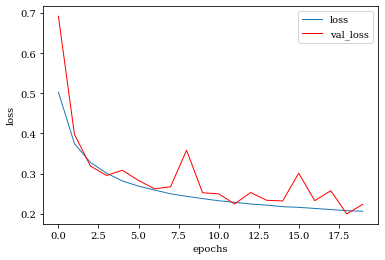

In [19]:
# テストデータの評価関数
def test_step(x, t):
    return val_step(x, t)

# 検証データの誤差の可視化
loss = hist['loss']
val_loss = hist['val_loss']

fig = plt.figure()
plt.rc('font', family='serif')
plt.plot(range(len(loss)), loss, linewidth=1,
             label='loss')
plt.plot(range(len(val_loss)), val_loss,
             color='red', linewidth=1,
             label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## 予測

In [20]:
test_loss = 0.
test_acc = 0.

for (x, t) in test_dataloader:
    x, t = x.to(device), t.to(device)
    loss, preds = test_step(x, t)
    test_loss += loss.item()
    test_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())

test_loss /= len(test_dataloader)
test_acc /= len(test_dataloader)
print('test_loss: {:.3f}, test_acc: {:.3f}'.format(
        test_loss,
        test_acc
))

test_loss: 0.220, test_acc: 0.931


In [0]:
save_path = "/content/drive/My Drive/study/CNN/weights/weights_vgg16_BN.pth"
torch.save(model.state_dict(), save_path)

# うまく行っている例

In [0]:
# モデルの構築
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.vgg = make_vgg()

        self.fc1 = nn.Linear(1024 * 19 * 19, 64)
        self.b1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 2)

        self.affine_drop = nn.Dropout(p=0.5)

    def forward(self, x):
        for k in range(len(self.vgg)):
            x = self.vgg[k](x)
        x = x.view(-1, 1024 * 19 * 19)
        x = F.relu(self.b1(self.fc1(x)))
        x = self.affine_drop(x)
        x = self.fc2(x)

        return x

In [0]:
# モデルの構築
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # cpuかgpuのどちらのデバイスを使っているかを代入する
model = VGG16().to(device)

In [24]:
for name, param in model.named_parameters():
    print(name)

vgg.0.weight
vgg.0.bias
vgg.2.weight
vgg.2.bias
vgg.5.weight
vgg.5.bias
vgg.7.weight
vgg.7.bias
vgg.10.weight
vgg.10.bias
vgg.12.weight
vgg.12.bias
vgg.14.weight
vgg.14.bias
vgg.17.weight
vgg.17.bias
vgg.19.weight
vgg.19.bias
vgg.21.weight
vgg.21.bias
vgg.24.weight
vgg.24.bias
vgg.26.weight
vgg.26.bias
vgg.28.weight
vgg.28.bias
vgg.31.weight
vgg.31.bias
vgg.33.weight
vgg.33.bias
fc1.weight
fc1.bias
b1.weight
b1.bias
fc2.weight
fc2.bias


In [25]:
vgg_weights = torch.load("/content/drive/My Drive/study/CNN/weights/vgg16_reducedfc.pth")
model.vgg.load_state_dict(vgg_weights)

<All keys matched successfully>

In [26]:
# 転移学習で学習させるパラメータを、変数params_to_updateに格納する
params_to_update = []

# 学習させるパラメータ名
update_param_names = ["fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias", "fc3.weight", "fc3.bias"]

# 学習させるパラメータ以外は勾配計算をなくし、変化しないように設定
for name, param in model.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

fc1.weight
fc1.bias
fc2.weight
fc2.bias


In [0]:
# 誤差関数の定義
compute_loss = nn.CrossEntropyLoss()

# 最適化手法の定義
optimizer = optimizers.Adam(model.parameters(),
                            lr=0.0000001,
                            betas=(0.9, 0.999), 
                            amsgrad=True)

## 学習

In [0]:
# 関数

## 学習の早期終了
class EarlyStopping:
    '''
    早期終了 (early stopping)
    '''
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience = patience
        self.verbose = verbose

    def __call__(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print('early stopping')
                return True
        else:
            self._step = 0
            self._loss = loss

        return False

## 1ステップ分の訓練のための関数
def train_step(x, t):
    model.train()  # モデルを訓練モードに設定する
    preds = model(x)  # modelにxを代入して、予測させる
    loss = compute_loss(preds, t)  # 予測値と正解との誤差を求める
    optimizer.zero_grad()  # 勾配を初期化する
    loss.backward()  # 勾配を計算する
    optimizer.step()  # パラメータを更新する
    return loss, preds

## 1ステップ分の訓練のための関数
def val_step(x, t):
    model.eval()  # モデルを評価モードに設定する
    preds = model(x)  # modelにxを代入して、予測させる
    loss = compute_loss(preds, t)  # 予測値と正解との誤差を求める    
    return loss, preds

## テストデータの評価関数
def test_step(x, t):
    return val_step(x, t)

In [0]:
# 学習
## 設定
epochs = 50  # エポック数を設定する
hist = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
es = EarlyStopping(patience=20, verbose=1)  # 10回以上誤差が小さくならないと早期終了する

np.random.seed(123)
torch.manual_seed(123)

## モデルの学習
for epoch in range(epochs):
    train_loss = 0.
    train_acc = 0.
    val_loss = 0.
    val_acc = 0.

    # 訓練パート
    for (x, t) in tqdm(train_dataloader, leave=False):
        x, t = x.to(device), t.to(device)
        loss, preds = train_step(x, t)
        train_loss += loss.item()
        train_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    # 検証パート
    for (x, t) in tqdm(val_dataloader, leave=False):
        x, t = x.to(device), t.to(device)
        loss, preds = val_step(x, t)
        val_loss += loss.item()
        val_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())

    val_loss /= len(val_dataloader)
    val_acc /= len(val_dataloader)

    # 学習状況を保存
    hist['loss'].append(train_loss)
    hist['accuracy'].append(train_acc)
    hist['val_loss'].append(val_loss)
    hist['val_accuracy'].append(val_acc)

    print('epoch: {}, loss: {:.3}, acc: {:.3f}'
          ', val_loss: {:.3}, val_acc: {:.3f}'.format(
              epoch+1,
              train_loss,
              train_acc,
              val_loss,
              val_acc
          ))

    if es(val_loss):
        break        

## モデルの評価

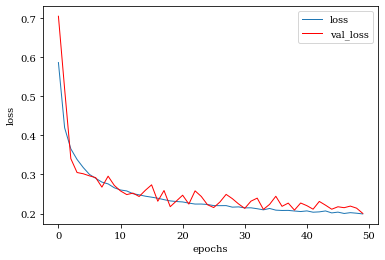

In [30]:
# テストデータの評価関数
def test_step(x, t):
    return val_step(x, t)

# 検証データの誤差の可視化
loss = hist['loss']
val_loss = hist['val_loss']

fig = plt.figure()
plt.rc('font', family='serif')
plt.plot(range(len(loss)), loss, linewidth=1,
             label='loss')
plt.plot(range(len(val_loss)), val_loss,
             color='red', linewidth=1,
             label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## 予測

In [31]:
test_loss = 0.
test_acc = 0.

for (x, t) in test_dataloader:
    x, t = x.to(device), t.to(device)
    loss, preds = test_step(x, t)
    test_loss += loss.item()
    test_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())

test_loss /= len(test_dataloader)
test_acc /= len(test_dataloader)
print('test_loss: {:.3f}, test_acc: {:.3f}'.format(
        test_loss,
        test_acc
))

test_loss: 0.196, test_acc: 0.946


In [0]:
save_path = "/content/drive/My Drive/study/CNN/weights/weights_vgg16_BND.pth"
torch.save(model.state_dict(), save_path)